<a href="https://colab.research.google.com/github/ProjectsMC/Deteccion_plagas_maiz/blob/main/Trainning_deteccionplagas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO DE INTELIGENCIA ARTIFICIAL**

MASTER EN AUTOMÁTICA Y ROBÓTICA DE LA UNIVERSIDAD POLITÉCNICA DE MADRID
GRUPO 7


*   Micaela Cabrera 23023
*   Ivonne Quizhe 23146

ENTRENAMIENTO DE RED NEURONAL PARA DETECCIÓN DE PLAGA EN PLANTAS DE MAÍZ





#Cargando librerias

In [ ]:
#Se importan las librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install opendatasets
import opendatasets as od
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# @markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# Carga de dataset

In [ ]:
# @title Carga del dataset para realizar el entrenamiento de la red
# @markdown Ingrese Kaggle Username: micaelacabrera
# @markdown
# @markdown Ingrese Kaggle Key: 477e8d75181c1078f94d32b395c7837a
dataset_link="https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset/data"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: micaelacabrera
Your Kaggle Key: ··········


100%|██████████| 161M/161M [00:04<00:00, 41.6MB/s]


#Entrenamiento de la red

In [ ]:
#Se define el tamaño de las imágenes
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

In [ ]:
#Se carga el dataset definido
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/corn-or-maize-leaf-disease-dataset/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [ ]:
#Se generan las clases en las que se divide el dataset
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
class_names = dataset.class_names
label_counts = {label: 0 for label in class_names}

for images, labels in dataset:
    for label in labels:
        label_name = class_names[label]
        label_counts[label_name] += 1

for label, count in label_counts.items():
    print(f"{label}: {count}")

Blight: 1146
Common_Rust: 1306
Gray_Leaf_Spot: 574
Healthy: 1162


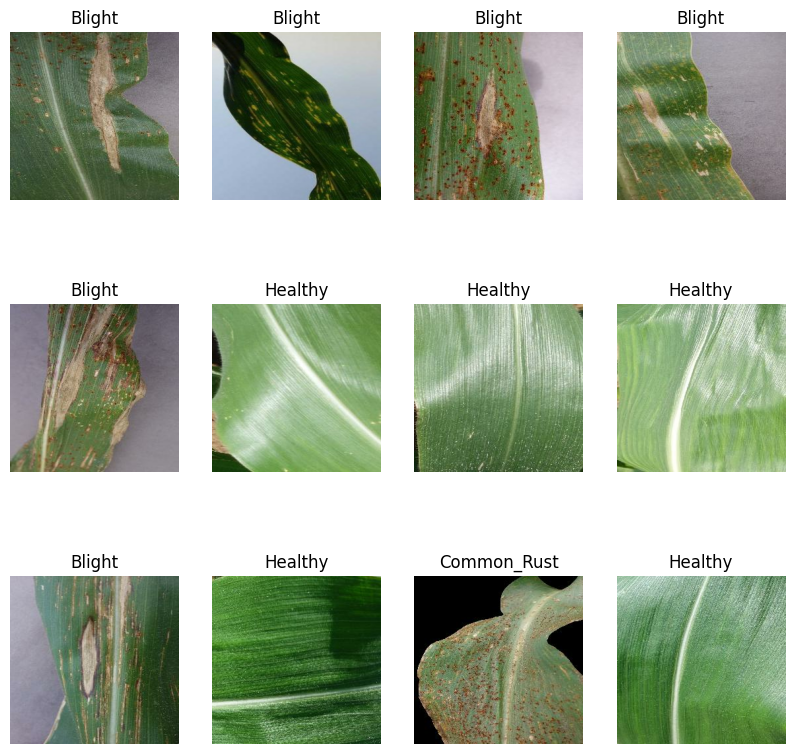

In [ ]:
#Se muestran 12 imágenes para corroborar que el dataset esta ok
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [ ]:
#Se toma un porcentaje del dataset para crear imágenes de test, validación y entrenamiento
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [ ]:
#Se corrobora el tamaño de los datasets
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 104

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Se redimensiona la imagen
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
#Se define las capas de la red neuronal Conv2D
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
#se compila el modelo antes presentado
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [ ]:
#Se realiza el entrenamiento
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)
history = model.fit(
train_ds,
epochs=70,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds,callbacks=callback)



Epoch 1/70
104/104 [==============================] - ETA: 0s - loss: 0.7897 - accuracy: 0.6661
Epoch 1: val_loss improved from inf to 0.58150, saving model to bestModel.h5
104/104 [==============================] - 36s 165ms/step - loss: 0.7897 - accuracy: 0.6661 - val_loss: 0.5815 - val_accuracy: 0.7764
Epoch 2/70
  1/104 [..............................] - ETA: 6s - loss: 0.8148 - accuracy: 0.7188

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.8017
Epoch 2: val_loss improved from 0.58150 to 0.39619, saving model to bestModel.h5
104/104 [==============================] - 6s 59ms/step - loss: 0.5008 - accuracy: 0.8017 - val_loss: 0.3962 - val_accuracy: 0.8438
Epoch 3/70
104/104 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8387
Epoch 3: val_loss improved from 0.39619 to 0.31068, saving model to bestModel.h5
104/104 [==============================] - 6s 59ms/step - loss: 0.3739 - accuracy: 0.8387 - val_loss: 0.3107 - val_accuracy: 0.8750
Epoch 4/70
104/104 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8544
Epoch 4: val_loss did not improve from 0.31068
104/104 [==============================] - 6s 57ms/step - loss: 0.3455 - accuracy: 0.8544 - val_loss: 0.3563 - val_accuracy: 0.8678
Epoch 5/70
104/104 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.8709
Epoch 5: val_loss did 

In [ ]:
from keras.models import load_model
model = load_model('/content/bestModel.h5')

In [ ]:
#Se procede a evaluar el modelo en el dataset de test
scores = model.evaluate(test_ds)

14/14 [==============================] - 14s 638ms/step - loss: 0.2179 - accuracy: 0.9509


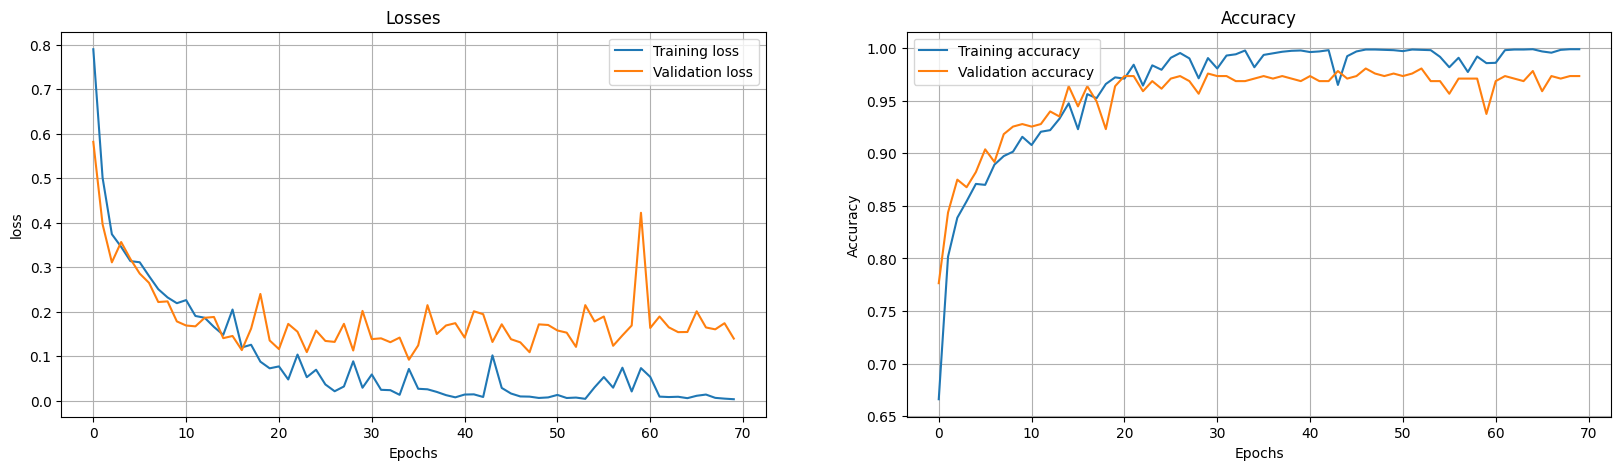

In [ ]:
#Curvas para conocer el performance de la red, precisión y pérdidas
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

#Validación

First Image to Predict :

Actual label: Healthy
1/1 [==============================] - 1s 618ms/step

Predicted label Healthy


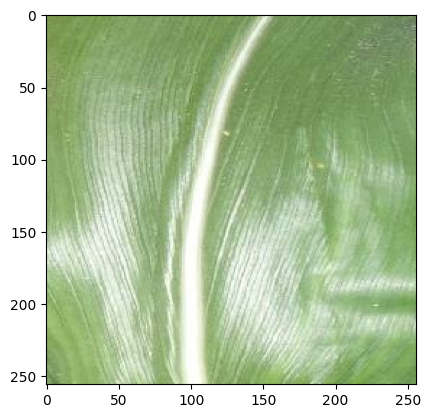

In [ ]:
#Se predice una imagen para corroborar funcionamiento de imagen
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [ ]:
#Se crea función para redimensionar imagen y ponerla a prueba con el modelo creado por la red
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 49ms/step


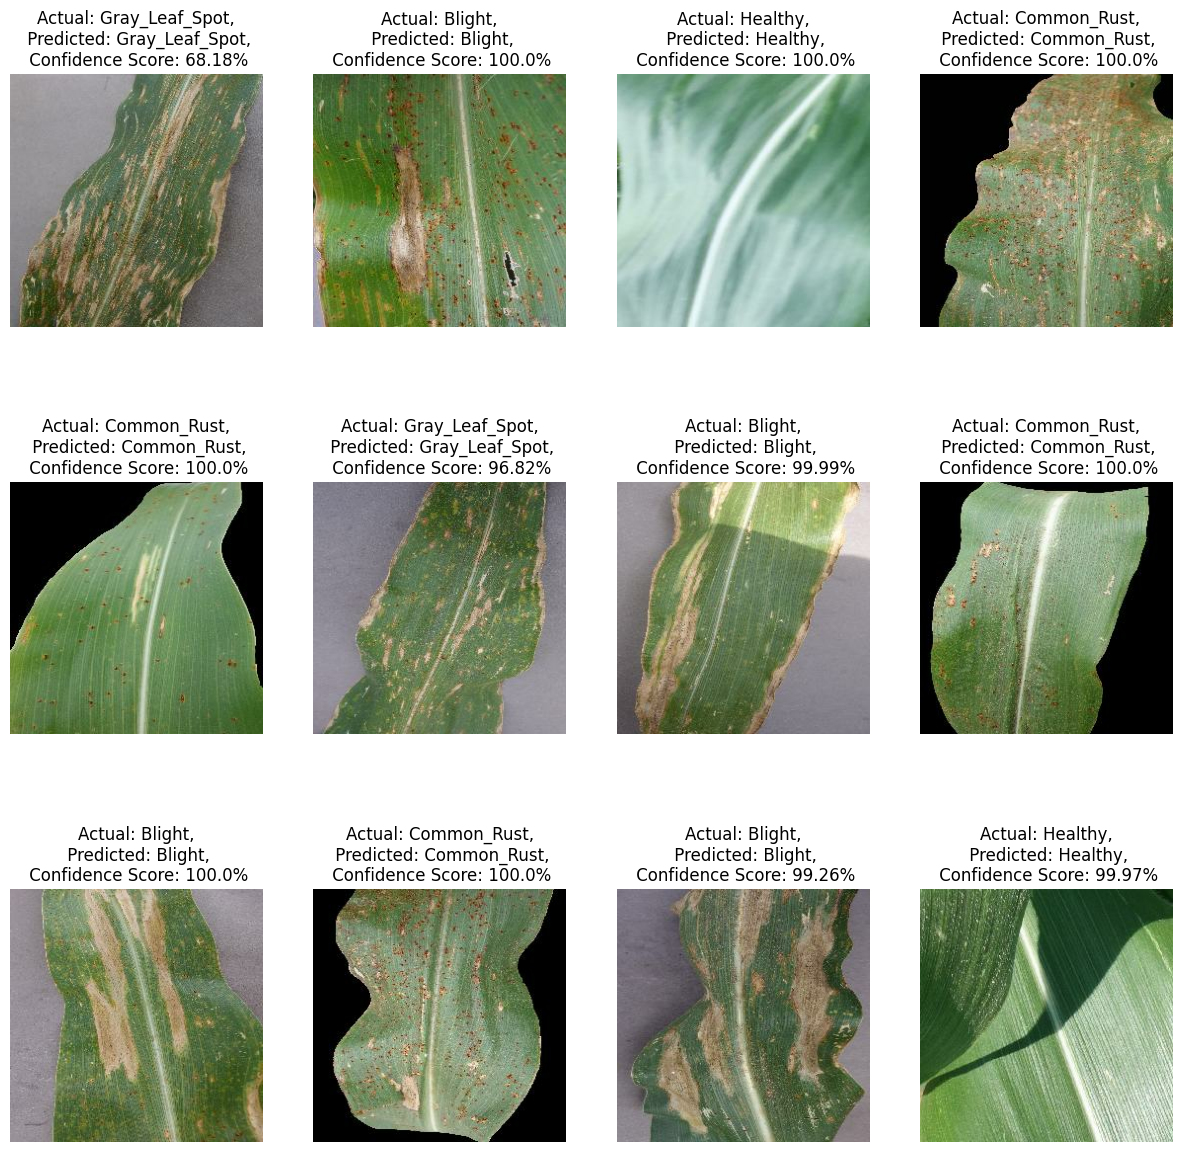

In [ ]:
#Se grafica imagenes del dataset de prueba
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
ACTUAL=[]
PREDICTED=[]
#Se toma el dataset y se generan vectores para crear la matriz de confusion
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(len(test_ds)):
    for i in range(BATCH_SIZE):
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        ACTUAL.append(actual_class)
        PREDICTED.append(predicted_class)

# Matriz de confusion

In [ ]:
print(PREDICTED)
print(ACTUAL)

['Gray_Leaf_Spot', 'Blight', 'Healthy', 'Common_Rust', 'Common_Rust', 'Gray_Leaf_Spot', 'Blight', 'Common_Rust', 'Blight', 'Common_Rust', 'Blight', 'Healthy']
['Gray_Leaf_Spot', 'Blight', 'Healthy', 'Common_Rust', 'Common_Rust', 'Gray_Leaf_Spot', 'Blight', 'Common_Rust', 'Blight', 'Common_Rust', 'Blight', 'Healthy']


Text(0.5, 25.722222222222214, 'Actual')

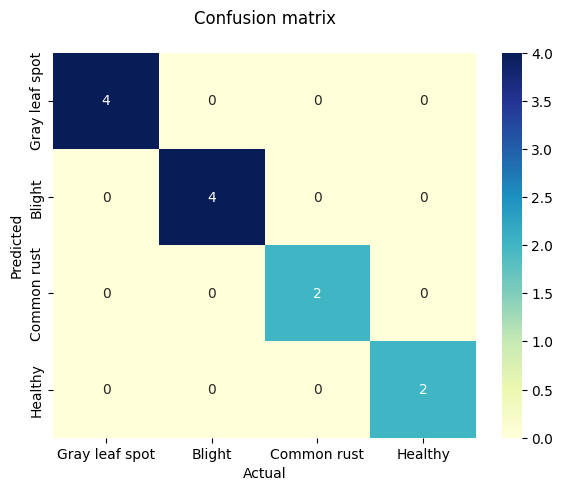

In [ ]:
# @title Se muestra matriz de confusion para el dataset destinado a test
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

#preds = best_model.predict(x_test)
#preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(ACTUAL, PREDICTED)
df_cm = pd.DataFrame(cm, index=['Gray leaf spot', 'Blight', 'Common rust', 'Healthy'], columns=['Gray leaf spot', 'Blight', 'Common rust', 'Healthy'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

#Probando imágenes

1/1 [==============================] - 0s 46ms/step


(-0.5, 255.5, 255.5, -0.5)

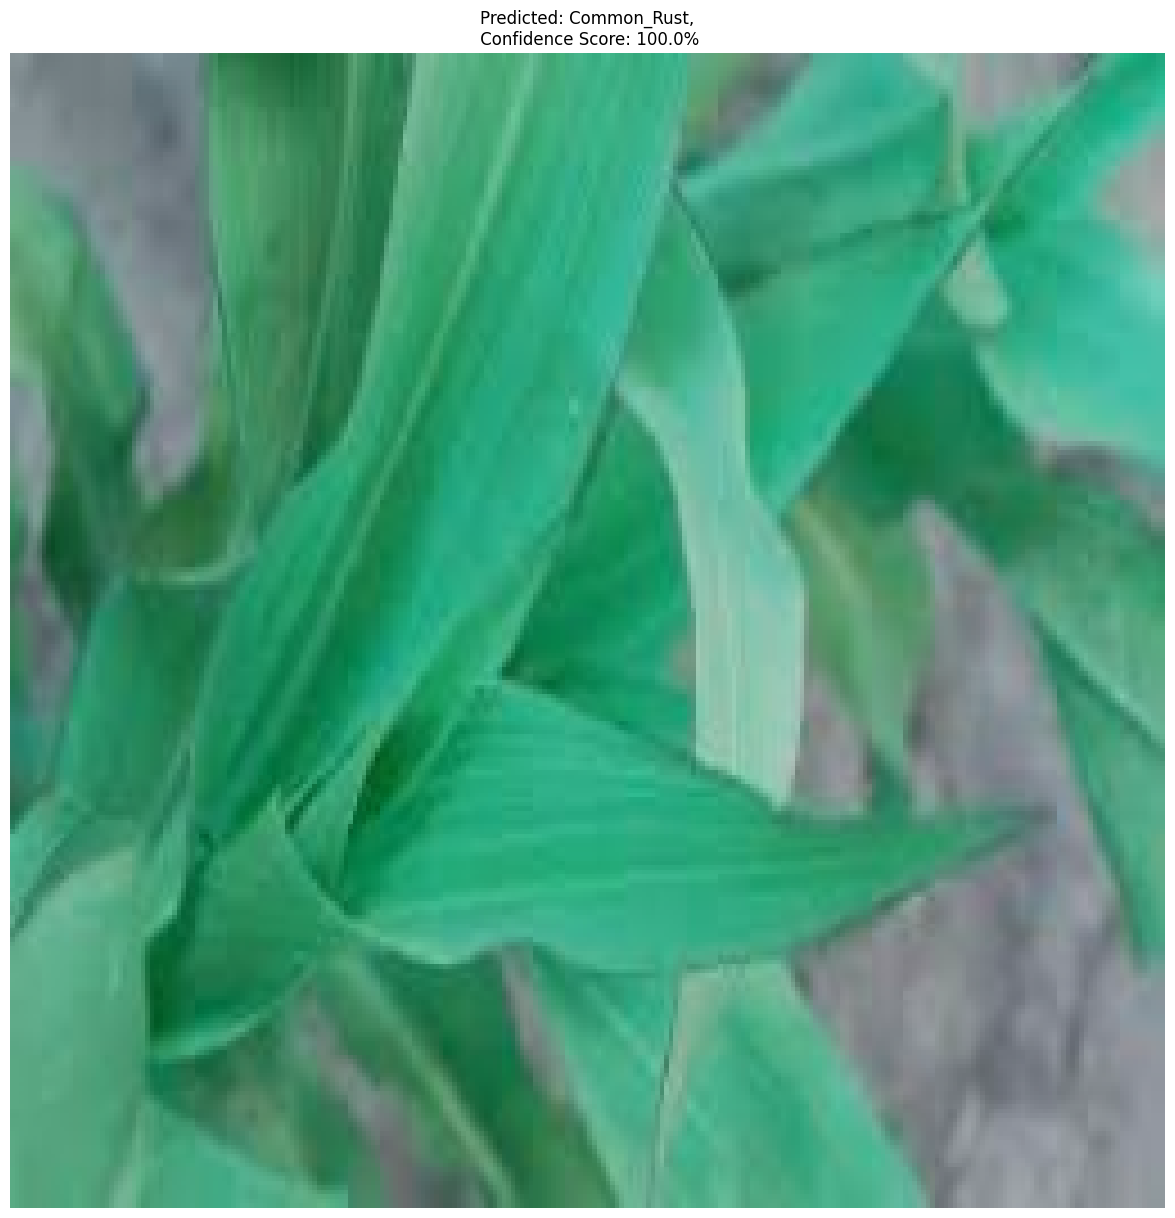

In [ ]:
# @title Ingrese el path de su imagen para realizar la prueba
Path = "/content/PHOTO-2023-12-17-19-53-23.jpg" # @param {type:"string"}
Imagetest=cv2.imread(Path)
img = cv2.resize(Imagetest,(256,256))
plt.figure(figsize=(15,15))
plt.imshow(img)
predicted_class , confidence = predict(model,img)
plt.title(f"Predicted: {predicted_class},\n Confidence Score: {confidence}%")
plt.axis("off")